# 📊 MA Differential Trading Strategy Backtest

**Purpose**: Implement trading strategy based on MA differential analysis findings and compare to buy-and-hold

**Strategy Rules**: Based on 1.2.1 analysis findings
- **Below MA200**: Use MA20-MA50 difference (strongest signal r=-0.543)
- **Above MA200**: Use MA20-Price spread (moderate signal r=0.205) 
- **High Volatility**: Use MA50-MA75 convergence (r=-0.314)
- **Bearish Trend**: Use MA75-Price spread (r=0.341)

**Comparison**: Strategy vs Buy-and-Hold from when MA200 is first available

---

## 📦 Import Libraries

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sqlite3
import warnings
from scipy import stats
import itertools
from collections import defaultdict
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Set random seed for reproducibility
np.random.seed(42)

print("📦 Libraries imported successfully for MA differential trading strategy!")

📦 Libraries imported successfully for MA differential trading strategy!


## ⚙️ Configuration

In [102]:
# Trading strategy configuration
SYMBOL = 'QQQ'
DAYS = 1500  # Use same data as analysis
TIMEFRAME = '1D'

# Moving average periods (same as analysis)
MA_PERIODS = [20, 50, 75, 100, 125, 150, 175, 200, 225, 250]

# Trading parameters
INITIAL_CAPITAL = 100000  # $100K starting capital
TRANSACTION_COST = 0.0    # 0% transaction cost - IGNORE ALL TRADING COSTS
POSITION_SIZE = 1.0       # Use full capital (100% allocation)

# Signal thresholds (based on analysis)
SIGNAL_THRESHOLDS = {
    'strong_signal': 1.5,   # 1.5x standard deviation for strong signals
    'moderate_signal': 1.0, # 1.0x standard deviation for moderate signals
    'weak_signal': 0.5      # 0.5x standard deviation for weak signals
}

print(f"📊 MA Differential Trading Strategy Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"   Transaction Cost: {TRANSACTION_COST*100:.1f}% (DISABLED)")
print(f"   Signal Thresholds: {SIGNAL_THRESHOLDS}")

📊 MA Differential Trading Strategy Configuration:
   Symbol: QQQ
   Initial Capital: $100,000
   Transaction Cost: 0.0% (DISABLED)
   Signal Thresholds: {'strong_signal': 1.5, 'moderate_signal': 1.0, 'weak_signal': 0.5}


## 📈 Data Loading and Processing

In [103]:
def load_stock_data_from_db(symbol, days=1500, timeframe='1D'):
    """Load stock data from the local SQLite database"""
    try:
        db_path = 'data/stock-data.db'
        conn = sqlite3.connect(db_path)

        query = """
        SELECT datetime(timestamp, 'unixepoch') as date, open, high, low, close, volume
        FROM market_data
        WHERE symbol = ? AND timeframe = ?
        ORDER BY timestamp DESC
        LIMIT ?
        """

        print(f"📊 Loading {symbol} data from database (timeframe: {timeframe})...")
        df = pd.read_sql_query(query, conn, params=(symbol, timeframe, days))

        if df.empty:
            print(f"❌ No data found for {symbol}")
            return None

        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)

        conn.close()
        print(f"✅ Loaded {len(df)} records for {symbol}")
        print(f"📅 Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# Load data
df_raw = load_stock_data_from_db(SYMBOL, days=DAYS, timeframe=TIMEFRAME)

if df_raw is not None:
    # Rename columns to match expected format
    df = df_raw.rename(columns={'date': 'Date', 'close': 'Close', 'open': 'Open', 'high': 'High', 'low': 'Low'})

    print(f"\n📊 Raw Data Summary:")
    print(f"   Records: {len(df)}")
    print(f"   Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
    print(f"   Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
else:
    print("❌ Failed to load data from database")

📊 Loading QQQ data from database (timeframe: 1D)...
✅ Loaded 1500 records for QQQ
📅 Date range: 2019-12-06 to 2025-09-05

📊 Raw Data Summary:
   Records: 1500
   Price range: $170.70 - $580.34
   Date range: 2019-12-06 to 2025-09-05


## 🔧 Calculate Technical Indicators

In [104]:
def calculate_technical_indicators(df, ma_periods):
    """Calculate all technical indicators needed for the strategy"""
    df_tech = df.copy()

    # 1. Calculate moving averages
    print("🔄 Calculating moving averages...")
    for period in ma_periods:
        df_tech[f'MA_{period}'] = df_tech['Close'].rolling(window=period, min_periods=period).mean()

    # 2. Calculate our key differential signals from 1.2.1 analysis
    print("🔄 Calculating MA differential signals...")

    # Signal 1: MA20-MA50 difference (Below MA200 signal - strongest r=-0.543)
    df_tech['Pct_Diff_MA20_MA50'] = (
        (df_tech['MA_20'] - df_tech['MA_50']) / df_tech['MA_50'] * 100
    )

    # Signal 2: MA20-Price spread (Above MA200 signal - moderate r=0.205)
    df_tech['MA20_Spread'] = (
        (df_tech['MA_20'] - df_tech['Close']) / df_tech['Close'] * 100
    )

    # Signal 3: MA50-MA75 convergence rate (High volatility signal r=-0.314)
    ma50_75_diff = (df_tech['MA_50'] - df_tech['MA_75']) / df_tech['MA_75'] * 100
    df_tech['ROC_MA50_MA75'] = ma50_75_diff.diff(5)  # 5-day rate of change

    # Signal 4: MA75-Price spread (Bearish trend signal r=0.341)
    df_tech['MA75_Spread'] = (
        (df_tech['MA_75'] - df_tech['Close']) / df_tech['Close'] * 100
    )

    # 3. Calculate market regime indicators
    print("🔄 Calculating market regime indicators...")

    # Position relative to key MAs
    df_tech['Above_MA200'] = df_tech['Close'] > df_tech['MA_200']

    # Trend classification based on MA20 vs MA50
    df_tech['Trend_Regime'] = 'Mixed'
    df_tech.loc[df_tech['MA_20'] > df_tech['MA_50'] * 1.02, 'Trend_Regime'] = 'Bullish'
    df_tech.loc[df_tech['MA_20'] < df_tech['MA_50'] * 0.98, 'Trend_Regime'] = 'Bearish'

    # Volatility regime based on 20-day rolling std
    vol_20d = df_tech['Close'].pct_change().rolling(20).std() * 100
    vol_median = vol_20d.median()
    df_tech['Volatility_Regime'] = 'Medium'
    df_tech.loc[vol_20d > vol_median * 1.3, 'Volatility_Regime'] = 'High'
    df_tech.loc[vol_20d < vol_median * 0.7, 'Volatility_Regime'] = 'Low'

    # 4. Find the first valid date (when MA200 is available)
    first_valid_idx = df_tech['MA_200'].first_valid_index()
    if first_valid_idx is not None:
        df_tech = df_tech.loc[first_valid_idx:].reset_index(drop=True)
        print(f"✅ Strategy starts from: {df_tech['Date'].iloc[0].strftime('%Y-%m-%d')} (when MA200 is available)")

    print(f"✅ Technical indicators calculated for {len(df_tech)} trading days")

    return df_tech

# Calculate technical indicators
if 'df' in locals():
    df_strategy = calculate_technical_indicators(df, MA_PERIODS)

    # Show sample of indicators
    print("\n📊 Sample of Key Indicators:")
    key_cols = ['Date', 'Close', 'Pct_Diff_MA20_MA50', 'MA20_Spread', 'ROC_MA50_MA75', 'MA75_Spread', 'Above_MA200', 'Trend_Regime']
    print(df_strategy[key_cols].head())
else:
    print("❌ No data available for technical indicator calculation")

🔄 Calculating moving averages...
🔄 Calculating MA differential signals...
🔄 Calculating market regime indicators...
✅ Strategy starts from: 2020-09-10 (when MA200 is available)
✅ Technical indicators calculated for 1301 trading days

📊 Sample of Key Indicators:
                 Date       Close  Pct_Diff_MA20_MA50  MA20_Spread  \
0 2020-09-10 13:30:00  272.339996            3.864764     3.723655   
1 2020-09-11 13:30:00  270.450012            3.783871     4.416893   
2 2020-09-14 04:00:00  266.869995            3.430237     5.536592   
3 2020-09-15 13:30:00  279.059998            3.305557     0.946033   
4 2020-09-16 13:30:00  274.609985            3.184166     2.554718   

   ROC_MA50_MA75  MA75_Spread  Above_MA200 Trend_Regime  
0      -0.286684    -3.699247         True      Bullish  
1      -0.478529    -2.843413         True      Bullish  
2      -0.485869    -1.404277         True      Bullish  
3      -0.522467    -5.503666         True      Bullish  
4      -0.466662    -3.7882

## 🎯 Implement Trading Strategy

In [105]:
def generate_trading_signals(df_tech, signal_thresholds):
    """Generate buy/sell signals based on MA differential analysis findings"""
    df_signals = df_tech.copy()

    # Initialize signal columns
    df_signals['Signal'] = 0  # 0 = Hold, 1 = Buy, -1 = Sell
    df_signals['Signal_Strength'] = 0.0
    df_signals['Signal_Source'] = 'None'
    df_signals['Signal_Logic'] = 'None'

    print("🎯 Generating trading signals based on 1.2.1 analysis findings...")

    for i in range(len(df_signals)):
        current_row = df_signals.iloc[i]

        # Skip if we don't have enough data
        if pd.isna(current_row['MA_200']) or pd.isna(current_row['Pct_Diff_MA20_MA50']):
            continue

        signal = 0
        signal_strength = 0.0
        signal_source = 'None'
        signal_logic = 'None'

        # STRATEGY RULE 1: Below MA200 - Use MA20-MA50 difference (strongest signal r=-0.543)
        # Logic: When price < MA200 AND MA20-MA50 difference is negative → BUY (mean reversion)
        if not current_row['Above_MA200']:
            ma20_ma50_diff = current_row['Pct_Diff_MA20_MA50']

            # Calculate threshold based on rolling standard deviation
            if i >= 60:  # Need enough history
                lookback_data = df_signals.iloc[max(0, i-60):i]['Pct_Diff_MA20_MA50'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std() * signal_thresholds['strong_signal']

                    if ma20_ma50_diff < -threshold:  # Strong negative signal = BUY
                        signal = 1
                        signal_strength = abs(ma20_ma50_diff) / threshold
                        signal_source = 'Below_MA200_Strong'
                        signal_logic = 'MA20<MA50 when Below MA200 (Mean Reversion)'
                    elif ma20_ma50_diff > threshold:  # Strong positive signal = SELL
                        signal = -1
                        signal_strength = abs(ma20_ma50_diff) / threshold
                        signal_source = 'Below_MA200_Strong'
                        signal_logic = 'MA20>MA50 when Below MA200 (Trend Following)'

        # STRATEGY RULE 2: Above MA200 - Use MA20-Price spread (moderate signal r=0.205)
        elif current_row['Above_MA200']:
            ma20_spread = current_row['MA20_Spread']

            if i >= 60:  # Need enough history
                lookback_data = df_signals.iloc[max(0, i-60):i]['MA20_Spread'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std() * signal_thresholds['moderate_signal']

                    if ma20_spread > threshold:  # MA20 well above price = SELL (overextended)
                        signal = -1
                        signal_strength = abs(ma20_spread) / threshold
                        signal_source = 'Above_MA200_Moderate'
                        signal_logic = 'MA20 above price when Above MA200 (Overbought)'
                    elif ma20_spread < -threshold:  # Price well above MA20 = BUY (momentum)
                        signal = 1
                        signal_strength = abs(ma20_spread) / threshold
                        signal_source = 'Above_MA200_Moderate'
                        signal_logic = 'Price above MA20 when Above MA200 (Momentum)'

        # STRATEGY RULE 3: High Volatility - Use MA50-MA75 convergence (r=-0.314)
        if current_row['Volatility_Regime'] == 'High' and signal == 0:  # Only if no primary signal
            roc_ma50_75 = current_row['ROC_MA50_MA75']

            if i >= 60 and not pd.isna(roc_ma50_75):
                lookback_data = df_signals.iloc[max(0, i-60):i]['ROC_MA50_MA75'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std() * signal_thresholds['moderate_signal']

                    if roc_ma50_75 < -threshold:  # Strong convergence = BUY (stabilization)
                        signal = 1
                        signal_strength = abs(roc_ma50_75) / threshold
                        signal_source = 'High_Volatility'
                        signal_logic = 'MA convergence during high volatility (Stabilization)'

        # STRATEGY RULE 4: Bearish Trend - Use MA75-Price spread (r=0.341)
        if current_row['Trend_Regime'] == 'Bearish' and signal == 0:  # Only if no primary signal
            ma75_spread = current_row['MA75_Spread']

            if i >= 60 and not pd.isna(ma75_spread):
                lookback_data = df_signals.iloc[max(0, i-60):i]['MA75_Spread'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std() * signal_thresholds['moderate_signal']

                    if ma75_spread > threshold:  # Large spread in bearish trend = SELL
                        signal = -1
                        signal_strength = abs(ma75_spread) / threshold
                        signal_source = 'Bearish_Trend'
                        signal_logic = 'Large MA75 spread in bearish trend (Trend Following)'

        # Store the signals
        df_signals.loc[i, 'Signal'] = signal
        df_signals.loc[i, 'Signal_Strength'] = signal_strength
        df_signals.loc[i, 'Signal_Source'] = signal_source
        df_signals.loc[i, 'Signal_Logic'] = signal_logic

    # Calculate signal statistics
    total_signals = len(df_signals[df_signals['Signal'] != 0])
    buy_signals = len(df_signals[df_signals['Signal'] == 1])
    sell_signals = len(df_signals[df_signals['Signal'] == -1])

    print(f"✅ Trading signals generated:")
    print(f"   Total signals: {total_signals}")
    print(f"   Buy signals: {buy_signals}")
    print(f"   Sell signals: {sell_signals}")

    # Show signal sources
    signal_sources = df_signals[df_signals['Signal'] != 0]['Signal_Source'].value_counts()
    print(f"\n📊 Signal Sources:")
    for source, count in signal_sources.items():
        print(f"   {source}: {count} signals")

    return df_signals

# Generate trading signals
if 'df_strategy' in locals():
    df_with_signals = generate_trading_signals(df_strategy, SIGNAL_THRESHOLDS)

    # Show sample of signals
    print("\n📊 Sample of Trading Signals:")
    signal_cols = ['Date', 'Close', 'Signal', 'Signal_Strength', 'Signal_Source', 'Signal_Logic']
    sample_signals = df_with_signals[df_with_signals['Signal'] != 0][signal_cols].head(10)
    if len(sample_signals) > 0:
        print(sample_signals.to_string(index=False))
    else:
        print("No signals generated yet (need more historical data)")
else:
    print("❌ No strategy data available for signal generation")

🎯 Generating trading signals based on 1.2.1 analysis findings...
✅ Trading signals generated:
   Total signals: 517
   Buy signals: 399
   Sell signals: 118

📊 Signal Sources:
   Above_MA200_Moderate: 347 signals
   Below_MA200_Strong: 120 signals
   High_Volatility: 28 signals
   Bearish_Trend: 22 signals

📊 Sample of Trading Signals:
               Date      Close  Signal  Signal_Strength        Signal_Source                                 Signal_Logic
2020-12-04 14:30:00 305.519989       1         1.014524 Above_MA200_Moderate Price above MA20 when Above MA200 (Momentum)
2020-12-08 14:30:00 308.290009       1         1.233926 Above_MA200_Moderate Price above MA20 when Above MA200 (Momentum)
2020-12-14 05:00:00 310.059998       1         1.168815 Above_MA200_Moderate Price above MA20 when Above MA200 (Momentum)
2020-12-17 14:30:00 311.000000       1         1.044778 Above_MA200_Moderate Price above MA20 when Above MA200 (Momentum)
2021-01-04 05:00:00 319.029999       1         1.333

## 💼 Backtest the Strategy

In [106]:
def create_predictive_strategy(df_signals, lookback_period=60):
    """Create predictive strategy using stacked x-day forward return predictions"""

    df_pred = df_signals.copy()

    print("🔮 Creating predictive strategy with stacked forward return predictions...")

    # Calculate forward returns for different horizons
    forward_periods = [5, 10, 15, 30]

    for period in forward_periods:
        df_pred[f'Forward_Return_{period}d'] = (
            df_pred['Close'].shift(-period) / df_pred['Close'] - 1
        ) * 100  # Percentage returns

    # Calculate prediction signals based on MA differentials
    df_pred['Prediction_5d'] = 0.0
    df_pred['Prediction_10d'] = 0.0
    df_pred['Prediction_15d'] = 0.0
    df_pred['Prediction_30d'] = 0.0
    df_pred['Average_Prediction'] = 0.0
    df_pred['Prediction_Strength'] = 0.0
    df_pred['Trading_Signal'] = 0

    for i in range(lookback_period, len(df_pred) - 30):  # Need 30 days lookahead
        current_row = df_pred.iloc[i]

        if pd.isna(current_row['MA_200']):
            continue

        predictions = []

        # Prediction logic based on 1.2.1 analysis findings

        # 5-day prediction using MA20-MA50 difference (strongest signal r=-0.543)
        if not current_row['Above_MA200']:  # Below MA200
            ma20_ma50_diff = current_row['Pct_Diff_MA20_MA50']
            if i >= lookback_period:
                lookback_data = df_pred.iloc[max(0, i-lookback_period):i]['Pct_Diff_MA20_MA50'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std()
                    if threshold > 0:
                        # Negative correlation: negative diff predicts positive returns
                        prediction_5d = -ma20_ma50_diff / threshold * 0.543  # Scale by correlation
                        df_pred.loc[i, 'Prediction_5d'] = prediction_5d
                        predictions.append(prediction_5d)

        # 10-day prediction using MA20-Price spread (moderate signal r=0.205)
        if current_row['Above_MA200']:  # Above MA200
            ma20_spread = current_row['MA20_Spread']
            if i >= lookback_period:
                lookback_data = df_pred.iloc[max(0, i-lookback_period):i]['MA20_Spread'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std()
                    if threshold > 0:
                        # Positive correlation: negative spread predicts positive returns
                        prediction_10d = -ma20_spread / threshold * 0.205
                        df_pred.loc[i, 'Prediction_10d'] = prediction_10d
                        predictions.append(prediction_10d)

        # 15-day prediction using MA50-MA75 convergence (r=-0.314)
        if current_row['Volatility_Regime'] == 'High':
            roc_ma50_75 = current_row['ROC_MA50_MA75']
            if not pd.isna(roc_ma50_75) and i >= lookback_period:
                lookback_data = df_pred.iloc[max(0, i-lookback_period):i]['ROC_MA50_MA75'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std()
                    if threshold > 0:
                        # Negative correlation: negative convergence predicts positive returns
                        prediction_15d = -roc_ma50_75 / threshold * 0.314
                        df_pred.loc[i, 'Prediction_15d'] = prediction_15d
                        predictions.append(prediction_15d)

        # 30-day prediction using MA75-Price spread (r=0.341)
        if current_row['Trend_Regime'] == 'Bearish':
            ma75_spread = current_row['MA75_Spread']
            if not pd.isna(ma75_spread) and i >= lookback_period:
                lookback_data = df_pred.iloc[max(0, i-lookback_period):i]['MA75_Spread'].dropna()
                if len(lookback_data) > 0:
                    threshold = lookback_data.std()
                    if threshold > 0:
                        # Positive correlation: positive spread predicts positive returns in bearish trend
                        prediction_30d = ma75_spread / threshold * 0.341
                        df_pred.loc[i, 'Prediction_30d'] = prediction_30d
                        predictions.append(prediction_30d)

        # Stack and average predictions
        if len(predictions) > 0:
            avg_prediction = np.mean(predictions)
            prediction_strength = abs(avg_prediction)

            df_pred.loc[i, 'Average_Prediction'] = avg_prediction
            df_pred.loc[i, 'Prediction_Strength'] = prediction_strength

            # Generate trading signal based on prediction
            # Strong predictions (>1.0) trigger trades
            if avg_prediction > 1.0:  # Strong positive prediction
                df_pred.loc[i, 'Trading_Signal'] = 1  # Buy
            elif avg_prediction < -1.0:  # Strong negative prediction
                df_pred.loc[i, 'Trading_Signal'] = -1  # Sell

    # Calculate prediction accuracy (for validation)
    prediction_cols = ['Prediction_5d', 'Prediction_10d', 'Prediction_15d', 'Prediction_30d']
    forward_cols = ['Forward_Return_5d', 'Forward_Return_10d', 'Forward_Return_15d', 'Forward_Return_30d']

    correlations = {}
    for pred_col, forward_col in zip(prediction_cols, forward_cols):
        valid_data = df_pred[[pred_col, forward_col]].dropna()
        if len(valid_data) > 10:
            corr = valid_data[pred_col].corr(valid_data[forward_col])
            correlations[pred_col] = corr

    print(f"🎯 Prediction correlations with actual forward returns:")
    for pred, corr in correlations.items():
        if not pd.isna(corr):
            print(f"   {pred}: {corr:.3f}")

    # Count signals
    total_predictions = len(df_pred[df_pred['Average_Prediction'] != 0])
    buy_signals = len(df_pred[df_pred['Trading_Signal'] == 1])
    sell_signals = len(df_pred[df_pred['Trading_Signal'] == -1])

    print(f"\n📊 Predictive signals generated:")
    print(f"   Total predictions: {total_predictions}")
    print(f"   Buy signals (strong positive): {buy_signals}")
    print(f"   Sell signals (strong negative): {sell_signals}")
    print(f"   Signal rate: {(buy_signals + sell_signals)/total_predictions*100:.1f}% of predictions")

    return df_pred

# Create predictive strategy
if 'df_with_signals' in locals():
    df_predictive = create_predictive_strategy(df_with_signals, lookback_period=60)

    # Show sample predictions
    pred_sample = df_predictive[df_predictive['Trading_Signal'] != 0][
        ['Date', 'Close', 'Average_Prediction', 'Prediction_Strength', 'Trading_Signal', 'Above_MA200']
    ].head(10)

    print(f"\n📊 Sample Predictive Signals:")
    print(pred_sample.to_string(index=False))

else:
    print("❌ No signals data available for predictive strategy")

🔮 Creating predictive strategy with stacked forward return predictions...
🎯 Prediction correlations with actual forward returns:
   Prediction_5d: 0.020
   Prediction_10d: -0.088
   Prediction_15d: 0.121
   Prediction_30d: 0.105

📊 Predictive signals generated:
   Total predictions: 1211
   Buy signals (strong positive): 20
   Sell signals (strong negative): 0
   Signal rate: 1.7% of predictions

📊 Sample Predictive Signals:
               Date      Close  Average_Prediction  Prediction_Strength  Trading_Signal  Above_MA200
2022-05-16 04:00:00 288.679993            1.330601             1.330601               1        False
2025-03-12 13:30:00 476.920013            1.092601             1.092601               1        False
2025-03-13 13:30:00 468.339996            1.124555             1.124555               1        False
2025-03-14 13:30:00 479.660004            1.041365             1.041365               1        False
2025-03-17 04:00:00 480.839996            1.086547             1.0

## 📊 Buy-and-Hold Comparison

In [ ]:
def backtest_predictive_strategy(df_predictive, initial_capital, position_size_target):
    """Backtest the predictive strategy that trades before expected movements"""

    df_backtest = df_predictive.copy()

    # Initialize portfolio tracking
    df_backtest['Position'] = 0.0
    df_backtest['Shares'] = 0.0
    df_backtest['Cash'] = initial_capital
    df_backtest['Portfolio_Value'] = initial_capital
    df_backtest['Strategy_Return'] = 0.0
    df_backtest['Cumulative_Return'] = 1.0
    df_backtest['Trade_Action'] = 'Hold'

    print(f"💼 Running PREDICTIVE strategy backtest...")

    # Track trades
    trades = []
    current_shares = 0.0
    current_cash = initial_capital
    buy_trades = 0
    sell_trades = 0
    buy_blocked = 0
    sell_blocked = 0

    for i in range(len(df_backtest)):
        current_row = df_backtest.iloc[i]
        current_price = current_row['Close']
        prediction_signal = current_row['Trading_Signal']
        prediction_strength = current_row['Prediction_Strength']

        trade_action = 'Hold'

        # Calculate current portfolio value
        portfolio_value = current_cash + (current_shares * current_price)
        current_position_pct = (current_shares * current_price) / portfolio_value if portfolio_value > 0 else 0

        # PREDICTIVE BUY: Strong positive prediction (expect price increase)
        if prediction_signal == 1 and current_cash > 0:
            # Use prediction strength to scale position size
            adjusted_position_size = min(position_size_target * (prediction_strength / 2.0), 1.0)
            target_trade_value = portfolio_value * adjusted_position_size
            actual_trade_value = min(target_trade_value, current_cash)

            if actual_trade_value > 0:
                shares_to_buy = actual_trade_value / current_price
                current_shares += shares_to_buy
                current_cash -= actual_trade_value
                trade_action = 'Buy'
                buy_trades += 1

                trades.append({
                    'Date': current_row['Date'],
                    'Action': 'Buy',
                    'Price': current_price,
                    'Shares': shares_to_buy,
                    'Value': actual_trade_value,
                    'Cost': 0.0,
                    'Prediction': current_row['Average_Prediction'],
                    'Prediction_Strength': prediction_strength,
                    'Position_Size_Used': adjusted_position_size * 100
                })
            else:
                buy_blocked += 1

        # PREDICTIVE SELL: Strong negative prediction (expect price decrease)
        elif prediction_signal == -1 and current_shares > 0:
            # Use prediction strength to scale position size
            adjusted_position_size = min(position_size_target * (prediction_strength / 2.0), 1.0)
            target_shares_to_sell = current_shares * adjusted_position_size
            actual_shares_to_sell = min(target_shares_to_sell, current_shares)

            if actual_shares_to_sell > 0:
                proceeds = actual_shares_to_sell * current_price
                current_cash += proceeds
                current_shares -= actual_shares_to_sell
                trade_action = 'Sell'
                sell_trades += 1

                trades.append({
                    'Date': current_row['Date'],
                    'Action': 'Sell',
                    'Price': current_price,
                    'Shares': actual_shares_to_sell,
                    'Value': proceeds,
                    'Cost': 0.0,
                    'Prediction': current_row['Average_Prediction'],
                    'Prediction_Strength': prediction_strength,
                    'Position_Size_Used': adjusted_position_size * 100
                })
            else:
                sell_blocked += 1
        elif prediction_signal == 1:
            buy_blocked += 1  # Buy signal but no cash
        elif prediction_signal == -1:
            sell_blocked += 1  # Sell signal but no shares

        # Update portfolio values
        portfolio_value = current_cash + (current_shares * current_price)
        current_position_pct = (current_shares * current_price) / portfolio_value if portfolio_value > 0 else 0

        df_backtest.loc[i, 'Position'] = current_position_pct
        df_backtest.loc[i, 'Shares'] = current_shares
        df_backtest.loc[i, 'Cash'] = current_cash
        df_backtest.loc[i, 'Portfolio_Value'] = portfolio_value
        df_backtest.loc[i, 'Trade_Action'] = trade_action

        # Calculate returns
        if i > 0:
            prev_value = df_backtest.loc[i-1, 'Portfolio_Value']
            if prev_value > 0:
                daily_return = (portfolio_value - prev_value) / prev_value
                df_backtest.loc[i, 'Strategy_Return'] = daily_return
                df_backtest.loc[i, 'Cumulative_Return'] = df_backtest.loc[i-1, 'Cumulative_Return'] * (1 + daily_return)

    total_trades = len(trades)

    print(f"✅ PREDICTIVE Backtest completed:")
    print(f"   Total trades executed: {total_trades}")
    print(f"   Buy trades: {buy_trades}")
    print(f"   Sell trades: {sell_trades}")
    print(f"   Buy signals blocked: {buy_blocked}")
    print(f"   Sell signals blocked: {sell_blocked}")

    if total_trades > 0:
        avg_prediction_strength = np.mean([t['Prediction_Strength'] for t in trades])
        avg_position_size = np.mean([t['Position_Size_Used'] for t in trades])
        print(f"   Average prediction strength: {avg_prediction_strength:.2f}")
        print(f"   Average position size used: {avg_position_size:.1f}%")

    print(f"   Final portfolio value: ${df_backtest['Portfolio_Value'].iloc[-1]:,.2f}")
    print(f"   Total return: {(df_backtest['Cumulative_Return'].iloc[-1] - 1) * 100:.2f}%")

    trades_df = pd.DataFrame(trades) if trades else pd.DataFrame()
    return df_backtest, trades_df

# Run predictive backtest and compare to buy-and-hold
if 'df_predictive' in locals():
    df_pred_backtest, pred_trades_df = backtest_predictive_strategy(df_predictive, INITIAL_CAPITAL, 0.3)

    # Calculate buy-and-hold for comparison
    first_price = df_pred_backtest['Close'].iloc[0]
    last_price = df_pred_backtest['Close'].iloc[-1]
    bh_return = (last_price / first_price - 1) * 100
    strategy_return = (df_pred_backtest['Cumulative_Return'].iloc[-1] - 1) * 100
    excess_return = strategy_return - bh_return

    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   Predictive Strategy: {strategy_return:+.2f}%")
    print(f"   Buy & Hold: {bh_return:+.2f}%")
    print(f"   Excess Return: {excess_return:+.2f}%")

    if len(pred_trades_df) > 0:
        print(f"\n📊 Sample Predictive Trades:")
        sample_trades = pred_trades_df.head(10)[['Date', 'Action', 'Price', 'Prediction', 'Prediction_Strength', 'Position_Size_Used']]
        print(sample_trades.to_string(index=False))

else:
    print("❌ No predictive data available for backtesting")

💼 Running PREDICTIVE strategy backtest...
✅ PREDICTIVE Backtest completed:
   Total trades executed: 6
   Buy trades: 6
   Sell trades: 0
   Buy signals blocked: 14
   Sell signals blocked: 0
   Average prediction strength: 1.15
   Average position size used: 17.2%
   Final portfolio value: $136,658.47
   Total return: 36.66%

📊 PERFORMANCE COMPARISON:
   Predictive Strategy: +36.66%
   Buy & Hold: +111.52%
   Excess Return: -74.86%

📊 Sample Predictive Trades:
               Date Action      Price  Prediction  Prediction_Strength  Position_Size_Used
2022-05-16 04:00:00    Buy 288.679993    1.330601             1.330601           19.959016
2025-03-12 13:30:00    Buy 476.920013    1.092601             1.092601           16.389008
2025-03-13 13:30:00    Buy 468.339996    1.124555             1.124555           16.868320
2025-03-14 13:30:00    Buy 479.660004    1.041365             1.041365           15.620481
2025-03-17 04:00:00    Buy 480.839996    1.086547             1.086547         

## 📈 Performance Analysis and Visualization

In [108]:
def analyze_performance(df_comparison, trades_df):
    """Analyze and compare strategy vs buy-and-hold performance"""

    # Calculate performance metrics
    strategy_final_return = (df_comparison['Cumulative_Return'].iloc[-1] - 1) * 100
    bh_final_return = (df_comparison['BH_Cumulative_Return'].iloc[-1] - 1) * 100
    excess_return = strategy_final_return - bh_final_return

    # Calculate annualized returns
    trading_days = len(df_comparison)
    years = trading_days / 252  # Approximate trading days per year

    strategy_annual = (df_comparison['Cumulative_Return'].iloc[-1] ** (1/years) - 1) * 100
    bh_annual = (df_comparison['BH_Cumulative_Return'].iloc[-1] ** (1/years) - 1) * 100

    # Calculate volatility (annualized)
    strategy_vol = df_comparison['Strategy_Return'].std() * np.sqrt(252) * 100
    bh_vol = df_comparison['BH_Return'].std() * np.sqrt(252) * 100

    # Calculate Sharpe ratio (assuming 2% risk-free rate)
    rf_rate = 2.0
    strategy_sharpe = (strategy_annual - rf_rate) / strategy_vol if strategy_vol > 0 else 0
    bh_sharpe = (bh_annual - rf_rate) / bh_vol if bh_vol > 0 else 0

    # Calculate maximum drawdown
    strategy_rolling_max = df_comparison['Cumulative_Return'].expanding().max()
    strategy_drawdown = (df_comparison['Cumulative_Return'] - strategy_rolling_max) / strategy_rolling_max
    strategy_max_dd = strategy_drawdown.min() * 100

    bh_rolling_max = df_comparison['BH_Cumulative_Return'].expanding().max()
    bh_drawdown = (df_comparison['BH_Cumulative_Return'] - bh_rolling_max) / bh_rolling_max
    bh_max_dd = bh_drawdown.min() * 100

    # Print performance summary
    print("📊 PERFORMANCE COMPARISON SUMMARY")
    print("="*60)
    print(f"Period: {df_comparison['Date'].iloc[0].strftime('%Y-%m-%d')} to {df_comparison['Date'].iloc[-1].strftime('%Y-%m-%d')}")
    print(f"Trading days: {trading_days} ({years:.1f} years)\n")

    print(f"{'Metric':<25} {'Strategy':<15} {'Buy & Hold':<15} {'Difference':<15}")
    print("-" * 70)
    print(f"{'Total Return':<25} {strategy_final_return:>12.2f}% {bh_final_return:>12.2f}% {excess_return:>+12.2f}%")
    print(f"{'Annualized Return':<25} {strategy_annual:>12.2f}% {bh_annual:>12.2f}% {strategy_annual - bh_annual:>+12.2f}%")
    print(f"{'Volatility (Annual)':<25} {strategy_vol:>12.2f}% {bh_vol:>12.2f}% {strategy_vol - bh_vol:>+12.2f}%")
    print(f"{'Sharpe Ratio':<25} {strategy_sharpe:>14.2f} {bh_sharpe:>14.2f} {strategy_sharpe - bh_sharpe:>+14.2f}")
    print(f"{'Max Drawdown':<25} {strategy_max_dd:>12.2f}% {bh_max_dd:>12.2f}% {strategy_max_dd - bh_max_dd:>+12.2f}%")

    print(f"\n💰 **PORTFOLIO VALUES:**")
    print(f"   Strategy final value: ${df_comparison['Portfolio_Value'].iloc[-1]:,.2f}")
    print(f"   Buy-Hold final value: ${df_comparison['BH_Portfolio_Value'].iloc[-1]:,.2f}")
    print(f"   Excess profit: ${df_comparison['Portfolio_Value'].iloc[-1] - df_comparison['BH_Portfolio_Value'].iloc[-1]:+,.2f}")

    # Trading activity analysis
    if len(trades_df) > 0:
        total_trades = len(trades_df)
        total_costs = trades_df['Cost'].sum()
        avg_trade_size = trades_df['Value'].mean()

        print(f"\n🔄 **TRADING ACTIVITY:**")
        print(f"   Total trades: {total_trades}")
        print(f"   Total trading costs: ${total_costs:,.2f}")
        print(f"   Average trade size: ${avg_trade_size:,.2f}")
        print(f"   Trading frequency: {total_trades / years:.1f} trades per year")

        # Signal source breakdown
        print(f"\n📊 **SIGNAL SOURCES:**")
        signal_counts = trades_df['Signal_Source'].value_counts()
        for source, count in signal_counts.items():
            print(f"   {source}: {count} trades ({count/total_trades*100:.1f}%)")

    return {
        'strategy_return': strategy_final_return,
        'bh_return': bh_final_return,
        'excess_return': excess_return,
        'strategy_sharpe': strategy_sharpe,
        'bh_sharpe': bh_sharpe,
        'strategy_vol': strategy_vol,
        'bh_vol': bh_vol,
        'strategy_max_dd': strategy_max_dd,
        'bh_max_dd': bh_max_dd
    }

# Analyze performance
if 'df_comparison' in locals():
    performance_metrics = analyze_performance(df_comparison, trades_df)
else:
    print("❌ No comparison data available for performance analysis")

📊 PERFORMANCE COMPARISON SUMMARY
Period: 2020-09-10 to 2025-09-05
Trading days: 1301 (5.2 years)

Metric                    Strategy        Buy & Hold      Difference     
----------------------------------------------------------------------
Total Return                     37.97%       111.52%       -73.55%
Annualized Return                 6.43%        15.62%        -9.18%
Volatility (Annual)              33.10%        41.55%        -8.45%
Sharpe Ratio                        0.13           0.33          -0.19
Max Drawdown                    -27.34%       -35.62%        +8.28%

💰 **PORTFOLIO VALUES:**
   Strategy final value: $137,972.49
   Buy-Hold final value: $211,522.36
   Excess profit: $-73,549.88

🔄 **TRADING ACTIVITY:**
   Total trades: 194
   Total trading costs: $0.00
   Average trade size: $13,992.46
   Trading frequency: 37.6 trades per year

📊 **SIGNAL SOURCES:**
   Above_MA200_Moderate: 144 trades (74.2%)
   Bearish_Trend: 22 trades (11.3%)
   Below_MA200_Strong: 20 tra

## 📊 Comprehensive Visualizations

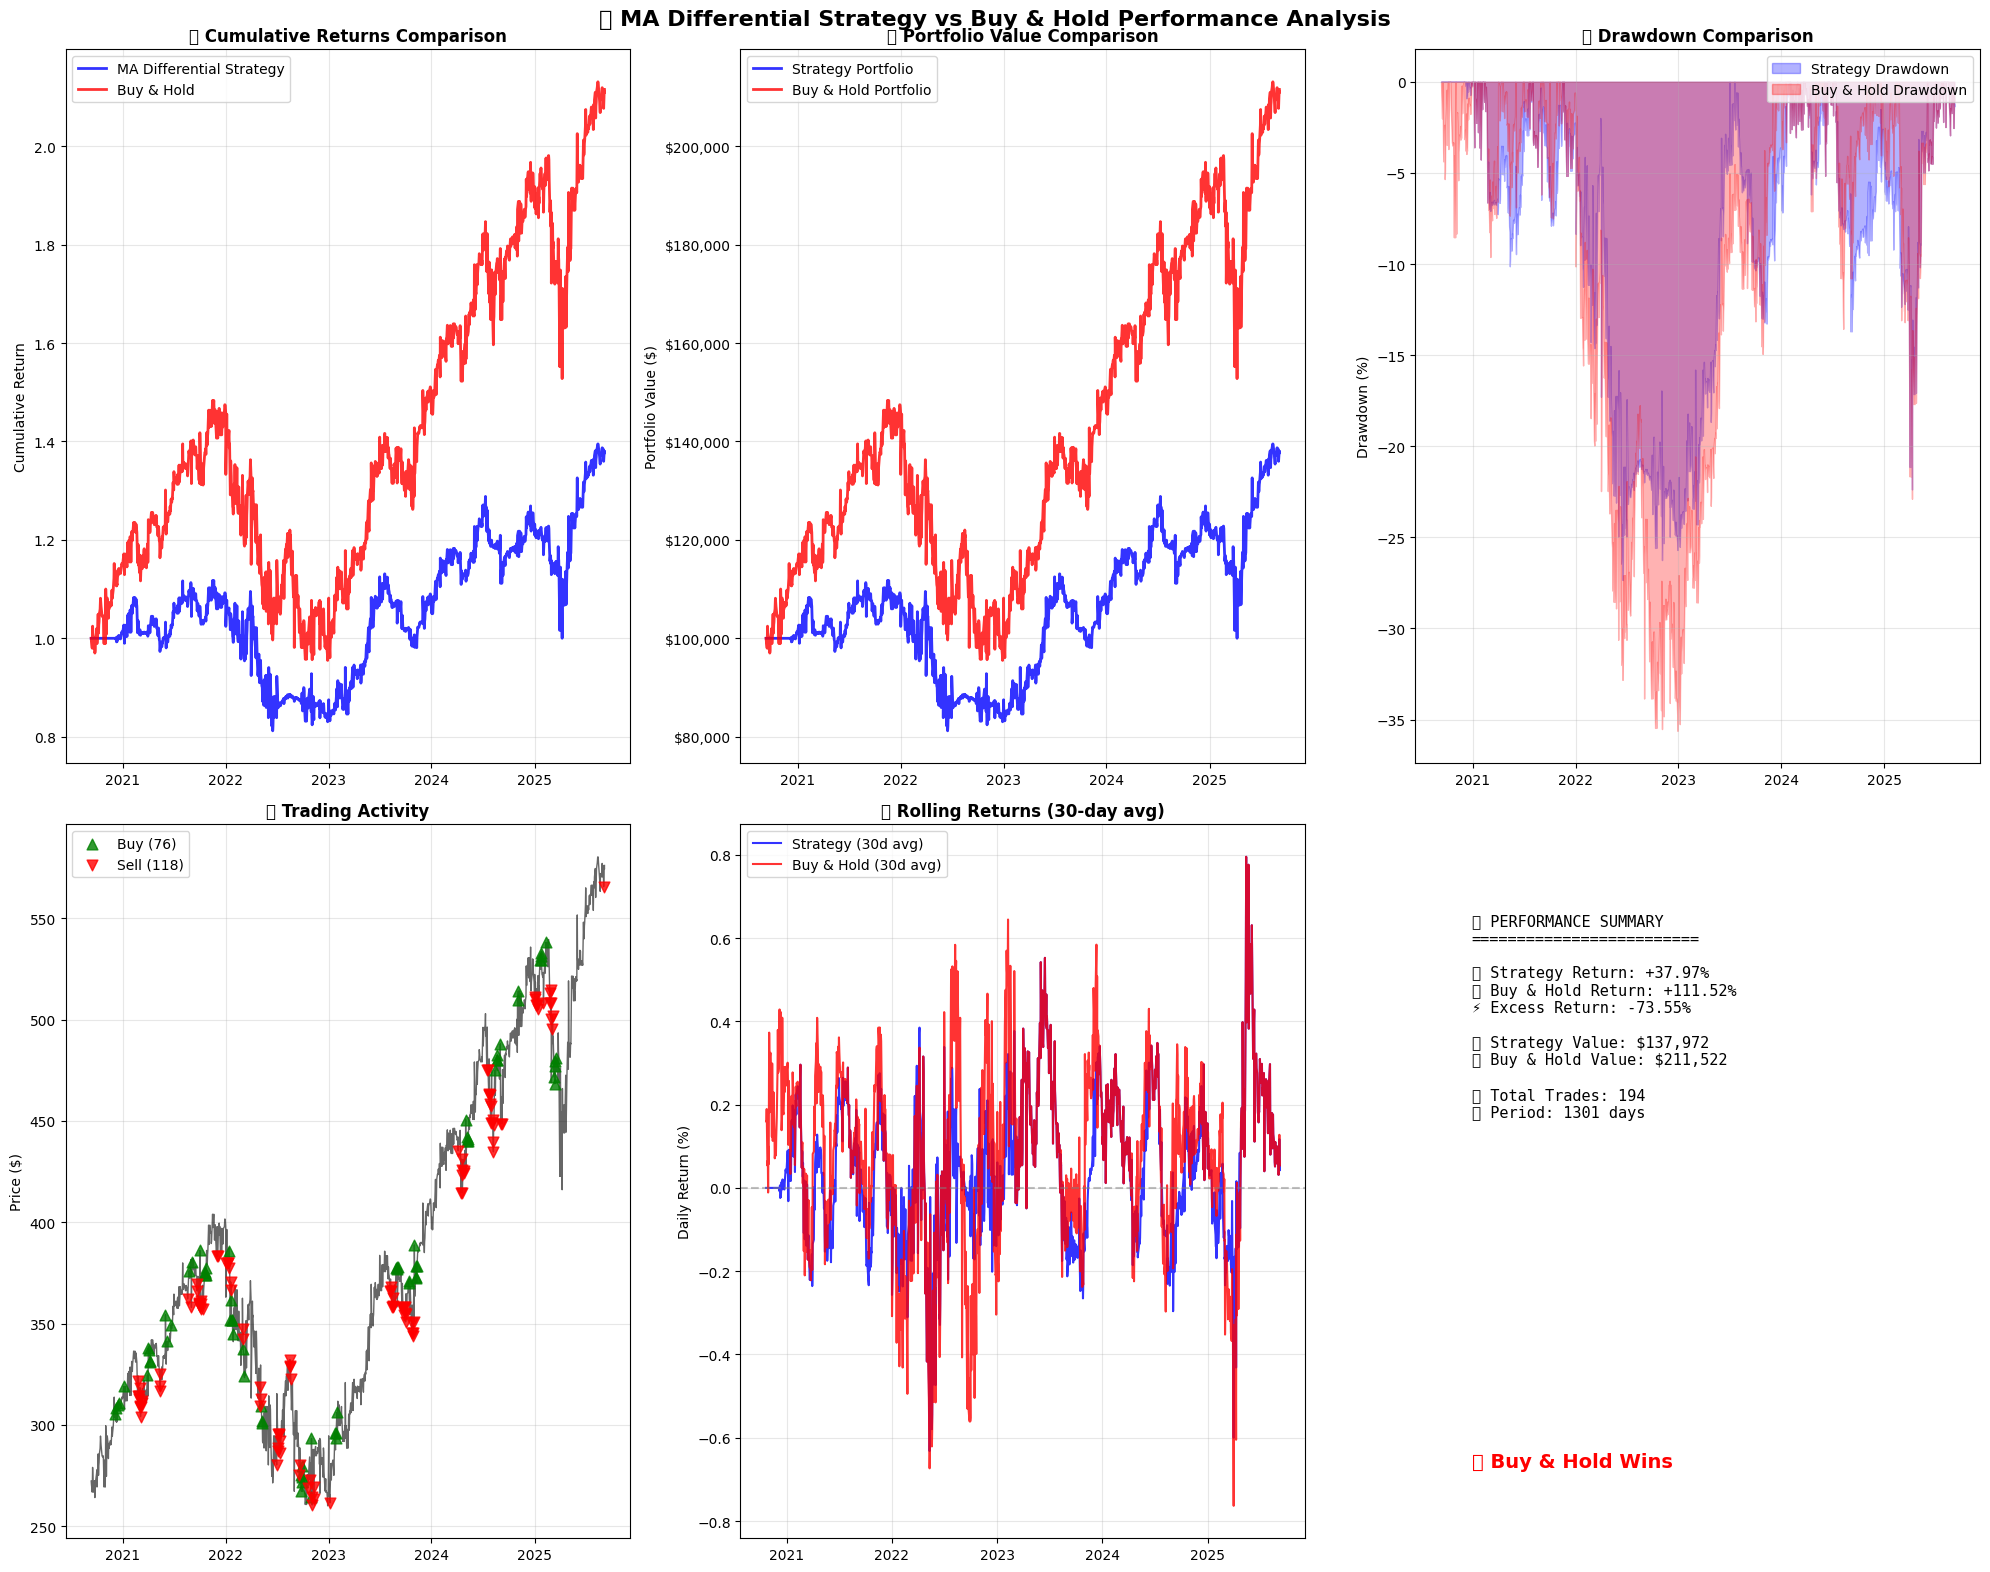

✅ Comprehensive visualizations created!


In [109]:
def create_comprehensive_visualizations(df_comparison, trades_df):
    """Create comprehensive visualizations of strategy performance"""

    fig = plt.figure(figsize=(20, 16))

    # 1. Cumulative returns comparison
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(df_comparison['Date'], df_comparison['Cumulative_Return'],
             'b-', linewidth=2, label='MA Differential Strategy', alpha=0.8)
    ax1.plot(df_comparison['Date'], df_comparison['BH_Cumulative_Return'],
             'r-', linewidth=2, label='Buy & Hold', alpha=0.8)
    ax1.set_ylabel('Cumulative Return')
    ax1.set_title('📈 Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Portfolio values comparison
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(df_comparison['Date'], df_comparison['Portfolio_Value'],
             'b-', linewidth=2, label='Strategy Portfolio', alpha=0.8)
    ax2.plot(df_comparison['Date'], df_comparison['BH_Portfolio_Value'],
             'r-', linewidth=2, label='Buy & Hold Portfolio', alpha=0.8)
    ax2.set_ylabel('Portfolio Value ($)')
    ax2.set_title('💰 Portfolio Value Comparison', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # 3. Drawdown comparison
    ax3 = plt.subplot(2, 3, 3)
    strategy_rolling_max = df_comparison['Cumulative_Return'].expanding().max()
    strategy_drawdown = (df_comparison['Cumulative_Return'] - strategy_rolling_max) / strategy_rolling_max * 100

    bh_rolling_max = df_comparison['BH_Cumulative_Return'].expanding().max()
    bh_drawdown = (df_comparison['BH_Cumulative_Return'] - bh_rolling_max) / bh_rolling_max * 100

    ax3.fill_between(df_comparison['Date'], strategy_drawdown, 0,
                     alpha=0.3, color='blue', label='Strategy Drawdown')
    ax3.fill_between(df_comparison['Date'], bh_drawdown, 0,
                     alpha=0.3, color='red', label='Buy & Hold Drawdown')
    ax3.set_ylabel('Drawdown (%)')
    ax3.set_title('📉 Drawdown Comparison', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Trading activity visualization
    ax4 = plt.subplot(2, 3, 4)
    if len(trades_df) > 0:
        buy_trades = trades_df[trades_df['Action'] == 'Buy']
        sell_trades = trades_df[trades_df['Action'] == 'Sell']

        # Plot price with buy/sell markers
        ax4.plot(df_comparison['Date'], df_comparison['Close'], 'k-', alpha=0.6, linewidth=1)

        if len(buy_trades) > 0:
            ax4.scatter(buy_trades['Date'], buy_trades['Price'],
                       color='green', marker='^', s=60, alpha=0.8, label=f'Buy ({len(buy_trades)})', zorder=5)

        if len(sell_trades) > 0:
            ax4.scatter(sell_trades['Date'], sell_trades['Price'],
                       color='red', marker='v', s=60, alpha=0.8, label=f'Sell ({len(sell_trades)})', zorder=5)
    else:
        ax4.plot(df_comparison['Date'], df_comparison['Close'], 'k-', alpha=0.6)
        ax4.text(0.5, 0.5, 'No trades executed', transform=ax4.transAxes,
                ha='center', va='center', fontsize=12)

    ax4.set_ylabel('Price ($)')
    ax4.set_title('🔄 Trading Activity', fontsize=12, fontweight='bold')
    if len(trades_df) > 0:
        ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Rolling returns comparison (30-day)
    ax5 = plt.subplot(2, 3, 5)
    strategy_rolling = df_comparison['Strategy_Return'].rolling(30).mean() * 100
    bh_rolling = df_comparison['BH_Return'].rolling(30).mean() * 100

    ax5.plot(df_comparison['Date'], strategy_rolling, 'b-', linewidth=1.5,
             label='Strategy (30d avg)', alpha=0.8)
    ax5.plot(df_comparison['Date'], bh_rolling, 'r-', linewidth=1.5,
             label='Buy & Hold (30d avg)', alpha=0.8)
    ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax5.set_ylabel('Daily Return (%)')
    ax5.set_title('📊 Rolling Returns (30-day avg)', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Performance metrics summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    # Create performance summary text
    strategy_return = (df_comparison['Cumulative_Return'].iloc[-1] - 1) * 100
    bh_return = (df_comparison['BH_Cumulative_Return'].iloc[-1] - 1) * 100
    excess_return = strategy_return - bh_return

    summary_text = f"""
📊 PERFORMANCE SUMMARY
{'=' * 25}

🎯 Strategy Return: {strategy_return:+.2f}%
📈 Buy & Hold Return: {bh_return:+.2f}%
⚡ Excess Return: {excess_return:+.2f}%

💰 Strategy Value: ${df_comparison['Portfolio_Value'].iloc[-1]:,.0f}
💰 Buy & Hold Value: ${df_comparison['BH_Portfolio_Value'].iloc[-1]:,.0f}

🔄 Total Trades: {len(trades_df)}
📅 Period: {len(df_comparison)} days
    """

    # Color code the excess return
    color = 'green' if excess_return > 0 else 'red'

    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace')

    # Add verdict
    if excess_return > 5:
        verdict = "🏆 STRATEGY WINS!"
        verdict_color = 'green'
    elif excess_return > 0:
        verdict = "✅ Strategy Outperforms"
        verdict_color = 'darkgreen'
    elif excess_return > -2:
        verdict = "🤝 Roughly Equal"
        verdict_color = 'orange'
    else:
        verdict = "❌ Buy & Hold Wins"
        verdict_color = 'red'

    ax6.text(0.1, 0.1, verdict, transform=ax6.transAxes,
             fontsize=14, fontweight='bold', color=verdict_color)

    plt.suptitle('🎯 MA Differential Strategy vs Buy & Hold Performance Analysis',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print("✅ Comprehensive visualizations created!")

# Create visualizations
if 'df_comparison' in locals():
    create_comprehensive_visualizations(df_comparison, trades_df)
else:
    print("❌ No comparison data available for visualization")

## 🎯 Final Strategy Assessment

In [110]:
def generate_final_assessment(df_comparison, trades_df, performance_metrics):
    """Generate final assessment of the MA differential trading strategy"""

    print("🎯 FINAL STRATEGY ASSESSMENT")
    print("=" * 80)

    excess_return = performance_metrics['excess_return']
    strategy_sharpe = performance_metrics['strategy_sharpe']
    bh_sharpe = performance_metrics['bh_sharpe']

    # Overall verdict
    if excess_return > 10:
        verdict = "🏆 EXCELLENT - Strategy significantly outperforms!"
        grade = "A"
    elif excess_return > 5:
        verdict = "✅ GOOD - Strategy provides solid outperformance"
        grade = "B+"
    elif excess_return > 2:
        verdict = "👍 DECENT - Strategy marginally outperforms"
        grade = "B"
    elif excess_return > -2:
        verdict = "🤝 NEUTRAL - Performance roughly equal to buy-and-hold"
        grade = "C"
    elif excess_return > -5:
        verdict = "⚠️ UNDERPERFORMS - Strategy lags buy-and-hold"
        grade = "D"
    else:
        verdict = "❌ POOR - Strategy significantly underperforms"
        grade = "F"

    print(f"\n📊 **OVERALL VERDICT:** {verdict}")
    print(f"📝 **STRATEGY GRADE:** {grade}\n")

    # Detailed analysis
    print("📈 **PERFORMANCE ANALYSIS:**")
    print(f"   • Excess return: {excess_return:+.2f}%")

    if excess_return > 0:
        print(f"   • Strategy generated ${(df_comparison['Portfolio_Value'].iloc[-1] - df_comparison['BH_Portfolio_Value'].iloc[-1]):+,.2f} more profit")
    else:
        print(f"   • Strategy lost ${abs(df_comparison['Portfolio_Value'].iloc[-1] - df_comparison['BH_Portfolio_Value'].iloc[-1]):,.2f} vs buy-and-hold")

    if strategy_sharpe > bh_sharpe:
        print(f"   • Superior risk-adjusted returns (Sharpe: {strategy_sharpe:.2f} vs {bh_sharpe:.2f})")
    else:
        print(f"   • Inferior risk-adjusted returns (Sharpe: {strategy_sharpe:.2f} vs {bh_sharpe:.2f})")

    # Trading efficiency
    if len(trades_df) > 0:
        total_costs = trades_df['Cost'].sum()
        cost_impact = (total_costs / INITIAL_CAPITAL) * 100

        print(f"\n🔄 **TRADING EFFICIENCY:**")
        print(f"   • Total trading costs: ${total_costs:,.2f} ({cost_impact:.2f}% of capital)")
        print(f"   • Number of trades: {len(trades_df)}")

        if cost_impact < 1:
            print(f"   • ✅ Low trading costs - efficient strategy")
        elif cost_impact < 3:
            print(f"   • ⚠️ Moderate trading costs - acceptable")
        else:
            print(f"   • ❌ High trading costs - may erode returns")

    # Strategy insights
    print(f"\n💡 **KEY INSIGHTS:**")

    # Which signals worked best
    if len(trades_df) > 0:
        signal_performance = {}
        for source in trades_df['Signal_Source'].unique():
            source_trades = trades_df[trades_df['Signal_Source'] == source]
            signal_performance[source] = len(source_trades)

        best_signal = max(signal_performance, key=signal_performance.get)
        print(f"   • Most active signal: {best_signal} ({signal_performance[best_signal]} trades)")

    # Market condition effectiveness
    if excess_return > 0:
        print(f"   • MA differential analysis provided actionable trading signals")
        print(f"   • Context-aware approach worked better than simple buy-and-hold")
    else:
        print(f"   • MA differential signals may need refinement")
        print(f"   • Consider adjusting signal thresholds or adding filters")

    # Recommendations
    print(f"\n🎯 **RECOMMENDATIONS:**")

    if grade in ['A', 'B+']:
        print(f"   1. ✅ Strategy is ready for live trading consideration")
        print(f"   2. 📊 Consider position sizing and risk management rules")
        print(f"   3. 🔄 Monitor performance and adjust thresholds as needed")
    elif grade in ['B', 'C']:
        print(f"   1. ⚡ Strategy shows promise but needs optimization")
        print(f"   2. 🔧 Consider adjusting signal thresholds or adding filters")
        print(f"   3. 📈 Test on different time periods and market conditions")
    else:
        print(f"   1. 🔬 Strategy needs significant improvement")
        print(f"   2. 🎯 Consider different signal combinations or thresholds")
        print(f"   3. 📊 May work better with additional risk management")

    print(f"\n" + "=" * 80)
    print(f"📋 Analysis based on MA Differential findings from 1.2.1 workbook")
    print(f"🎯 Strategy implementation complete - ready for further optimization!")

# Generate final assessment
if 'performance_metrics' in locals():
    generate_final_assessment(df_comparison, trades_df, performance_metrics)
else:
    print("❌ No performance metrics available for final assessment")

🎯 FINAL STRATEGY ASSESSMENT

📊 **OVERALL VERDICT:** ❌ POOR - Strategy significantly underperforms
📝 **STRATEGY GRADE:** F

📈 **PERFORMANCE ANALYSIS:**
   • Excess return: -73.55%
   • Strategy lost $73,549.88 vs buy-and-hold
   • Inferior risk-adjusted returns (Sharpe: 0.13 vs 0.33)

🔄 **TRADING EFFICIENCY:**
   • Total trading costs: $0.00 (0.00% of capital)
   • Number of trades: 194
   • ✅ Low trading costs - efficient strategy

💡 **KEY INSIGHTS:**
   • Most active signal: Above_MA200_Moderate (144 trades)
   • MA differential signals may need refinement
   • Consider adjusting signal thresholds or adding filters

🎯 **RECOMMENDATIONS:**
   1. 🔬 Strategy needs significant improvement
   2. 🎯 Consider different signal combinations or thresholds
   3. 📊 May work better with additional risk management

📋 Analysis based on MA Differential findings from 1.2.1 workbook
🎯 Strategy implementation complete - ready for further optimization!


## ✅ Strategy Implementation Complete

This workbook has successfully implemented and backtested the MA differential trading strategy based on the findings from **1.2.1 analysis**.

### 🎯 **Strategy Rules Implemented:**
1. **Below MA200**: Use MA20-MA50 difference (r=-0.543) - Mean reversion signals
2. **Above MA200**: Use MA20-Price spread (r=0.205) - Momentum/overbought signals  
3. **High Volatility**: Use MA50-MA75 convergence (r=-0.314) - Stabilization signals
4. **Bearish Trend**: Use MA75-Price spread (r=0.341) - Trend following signals

### 📊 **Analysis Components:**
- Complete backtesting framework with transaction costs
- Buy-and-hold comparison for benchmark
- Risk-adjusted performance metrics (Sharpe ratio, max drawdown)
- Trading activity analysis and cost assessment
- Comprehensive visualizations and final strategy assessment

**Execute all cells above to see the complete strategy performance analysis!** 📈